# Testing KERAS classification with MLP

In [1]:
from fastespy.mlkeras.evaluation import (
     SplitData,
     learning_curve,
     SignificanceMetric
)

from fastespy.mlscikit.hyperpartune import (
     get_sig_bkg_rate_eff,
     get_tp_fp_fn,
)
from fastespy.mlkeras import models
from fastespy.mlscikit.hyperpartune import MLHyperParTuning
from fastespy.io.readpydata import convert_data_to_ML_format, load_data_rikhav
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import sys
import glob
import os
import tempfile
import logging
import numpy as np
import tqdm
import time
from pathlib import PosixPath
from fastespy.utils import init_logging

In [2]:
%matplotlib inline

In [3]:
init_logging("INFO", color=True)

## Read data 

In [4]:
path = "/Users/manuelmeyer/Documents/TESData/IntrinsicsData_NewSetup/" # May 2021 data
prefix = "IntrinsicsData_NewSetup"

path = "/Users/manuelmeyer/Documents/TESData/August2020/" # August 2021 data
#\path = "/Users/manuelmeyer/Python/TESdata/data-01152021//" # August 2020 data
prefix = "August2020"

in_dir = PosixPath(path)
files = glob.glob(os.path.join(path, '*.npy'))

print(len(files))
#files

if not len(files):
    path = "/Users/manuelmeyer/Python/TESdata/data-05122021/"
    in_dir = PosixPath(path)
    files = glob.glob(os.path.join(path, '*.npy'))
    print(len(files))

17


In [5]:
files = list(in_dir.glob("*.npy"))

logging.info("Using files:")
for f in files:
    logging.info(f)

# define the feature names
feature_names = []
remove = ['data', 'time', 'pulse integral raw', 'voltage error',
          'error', 'start time in hrs', 'end time in hrs',
          'trigger time'
        ]

remove.append('constant')  # this seems to help

x = np.load(files[0], allow_pickle=True).tolist()
for k in x[1].keys():
    if not k in remove and not 'error' in k:
        feature_names.append(k)

logging.info("Using features names {}".format(feature_names))

 # define light cleaning cuts
light_cleaning_cuts = {
     "chi2 reduced": "chi2 < 6.",
    "decay time": "decay < 10.e-6",
    "trigger time": "(trigger >= 29.5e-6) & (trigger <= 30.8e-6)",  # from gaussian fit, 5 sigma interval
}

# read the data
result, data, t_tot_hrs = load_data_rikhav(files, feature_names, light_cleaning_cuts=light_cleaning_cuts)

2426790526.py:   3 --- INFO: Using files:
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-16-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-3-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHz-light-000-fit.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GBWP-intrinsics-50MHz-20mV-1day-9-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-13-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-1day-14-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelmeyer/Documents/TESData/August2020/0.3RN-1.5GHzGBWP-intrinsics-50MHz-20mV-72hrs-1-fit000.npy
2426790526.py:   5 --- INFO: /Users/manuelme

Convert raw data into machine learning format with samples and features

In [6]:
print (data['time'].shape)
print (data['data'].shape) # n samples x n features
print (result['type'].shape)  # n samples
print (np.sum(result['type']), np.sum(~result['type']))  # n samples

(40646, 10000)
(40646, 10000)
(40646,)
1066 39580


In [7]:
downsample = 40 # use only every n-th data point / decrease sampling frequency by this amount
factor_x = 1e6  # seconds to micro seconds
factor_y = 1e3 # V to mV
prune_pre = 1000
prune_post = 6000

In [8]:
X_raw = data['data'][:,prune_pre:prune_post] * factor_y
X_raw = X_raw[:,::downsample]
# cut off start and end
# size:
X_raw.shape

(40646, 125)

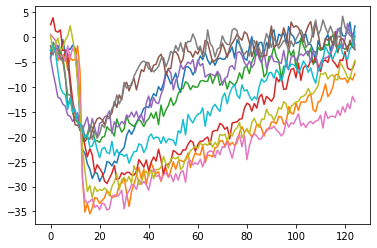

In [9]:
for i in range(10):
    plt.plot(X_raw[i])

In [10]:
# for each time series: 
# standardize by subtracting mean and dividing by variance

# think more about this: you really want to do this also in this way???
#X_raw = (X_raw.T - X_raw.mean(axis=1)).T
#X_raw = (X_raw.T / np.std(X_raw, axis=1)).T

##X_raw = (X_raw - X_raw.mean()).T
##X_raw = (X_raw / np.std(X_raw)).T

In [11]:
y_raw = result['type']

Split the data

In [12]:
sd = SplitData(X_raw, y_raw, n_splits=5, stratify=True, random_state=42)

In [13]:
i_split = 0
#X_train, X_test, y_train, y_test = sd.get_split(i_split)
X_train_raw, X_val_raw, y_train, y_val = sd.get_split_with_test_set(m=i_split, n=0)

In [14]:
# znorm 
std_ = X_train_raw.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
X_train_raw = (X_train_raw - X_train_raw.mean(axis=1, keepdims=True)) / std_

std_ = X_val_raw.std(axis=1, keepdims=True)
std_[std_ == 0] = 1.0
X_val_raw = (X_val_raw - X_val_raw.mean(axis=1, keepdims=True)) / std_

Normalize the data

In [15]:
y_raw.astype(bool)

array([False, False, False, ..., False, False, False])

9.237055564881302e-17
1.0


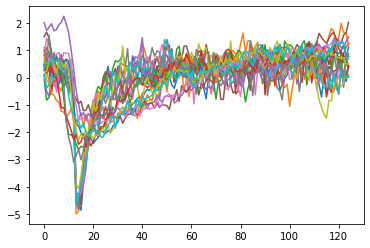

In [16]:
for i in range(10):
    plt.plot(X_train_raw[y_train.astype(bool),:][i])
    
for i in range(10):
    plt.plot(X_train_raw[~y_train.astype(bool),:][i])

print(np.mean(X_train_raw[0]))
print(np.var(X_train_raw[0]))

In [17]:
# Univariate time series, i.e., only one feature for each time step
# We need to transform the data so that the shape is (n_batch, n_time_steps, n_features)
X_train_raw = X_train_raw[..., np.newaxis]
X_val_raw = X_val_raw[..., np.newaxis]
print(X_train_raw.shape)
print(X_val_raw.shape)

(26012, 125, 1)
(6504, 125, 1)


#### Define new metric

In [18]:
sm = SignificanceMetric(N_tot=y_train.size + y_val.size + sd.y_test.size,
                        t_obs=t_tot_hrs * 3600.,
                        #dtype=tf.float
                       )
metrics = list(models.metrics)
metrics.append(sm)

### Define the CNN Model

Inspired by https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/fcn.py
and see also https://keras.io/examples/timeseries/timeseries_classification_from_scratch/ as well as https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/blob/master/FCN.py

In [19]:
initial_bias, initial_loss = models.initial_output_bias(y_train)
print(initial_bias, initial_loss)

[-3.61622191] [0.12120253]


In [20]:
def build_model(input_shape, metrics, output_bias=None, learning_rate=1e-2):
    
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    
    input_layer = keras.layers.Input(shape=(input_shape), name="input")
    
    #conv1 = keras.layers.Conv1D(filters=128, kernel_size=8, padding='same', name="conv1")(input_layer)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', name="conv1")(input_layer)
    conv1 = keras.layers.BatchNormalization(name="BN1")(conv1)
    conv1 = keras.layers.Activation(activation='relu', name="relu1")(conv1)
    
    #conv2 = keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', name="conv2")(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', name="conv2")(conv1)
    conv2 = keras.layers.BatchNormalization(name="BN2")(conv2)
    conv2 = keras.layers.Activation('relu', name="relu2")(conv2)

    ##conv3 = keras.layers.Conv1D(128, kernel_size=3,padding='same', name="conv3")(conv2)
    #conv3 = keras.layers.Conv1D(64, kernel_size=3,padding='same', name="conv3")(conv2)
    #conv3 = keras.layers.BatchNormalization(name="BN3")(conv3)
    #conv3 = keras.layers.Activation('relu', name="relu3")(conv3)
    
    #gap_layer = keras.layers.GlobalAveragePooling1D(name="gap")(conv3)
    gap_layer = keras.layers.GlobalAveragePooling1D(name="gap")(conv2)
    
    output_layer = keras.layers.Dense(1, activation='sigmoid', name='output',
                                      bias_initializer=output_bias)(gap_layer)
    
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=adam,
        metrics=metrics
    )

    return model

In [21]:
model = build_model(X_train_raw.shape[1:], metrics, output_bias=initial_bias)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 125, 1)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 64)           256       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 125, 64)           256       
_________________________________________________________________
relu1 (Activation)           (None, 125, 64)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           12352     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 125, 64)           256       
_________________________________________________________________
relu2 (Activation)           (None, 125, 64)           0     

Initial predictions

In [23]:
predict_example = model.predict(X_train_raw[:10])
print(predict_example, y_train.sum() / y_train.size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-02-02 16:20:52.499778: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-02 16:20:52.500092: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz
ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x176e44c10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[0.02462179]
 [0.02448164]
 [0.02456434]
 [0.02459969]
 [0.02463473]
 [0.02454637]
 [0.02453983]
 [0.02452491]
 [0.02461015]
 [0.02456429]] 0.0261802245117638


In [24]:
results = model.evaluate(X_train_raw, y_train, verbose=0, return_dict=True)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x175f3d1f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <bound method SignificanceMetric.update_state of <fastespy.mlkeras.evaluation.SignificanceMetric object at 0x176fb6eb0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <bound method SignificanceMetric.result of <fastespy.mlkeras.evaluation.SignificanceMetric object at 0x176fb6eb0>> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [25]:
print(results)

{'loss': 0.12124151736497879, 'tp': 0.0, 'fp': 0.0, 'tn': 25331.0, 'fn': 681.0, 'accuracy': 0.9738197922706604, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'prc': 0.026180224493145943, 'significance': 0.0}


In [26]:
results['loss'], initial_loss

(0.12124151736497879, array([0.12120253]))

Save the inital weights

In [27]:
initial_weights = os.path.join(tempfile.mkdtemp(), f'initial_weights')
model.save_weights(initial_weights)

### Train the full model

In [28]:
model.summary()
model.load_weights(initial_weights)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 125, 1)]          0         
_________________________________________________________________
conv1 (Conv1D)               (None, 125, 64)           256       
_________________________________________________________________
BN1 (BatchNormalization)     (None, 125, 64)           256       
_________________________________________________________________
relu1 (Activation)           (None, 125, 64)           0         
_________________________________________________________________
conv2 (Conv1D)               (None, 125, 64)           12352     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 125, 64)           256       
_________________________________________________________________
relu2 (Activation)           (None, 125, 64)           0     

In [29]:
keras.utils.plot_model(model, "model.png")

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [ ]:
EPOCHS = 200
#BATCH_SIZE = 2048  # large enough so that you have enough signal samples in each batch
BATCH_SIZE = 2048

t0 = time.time()
baseline_history = models.train_model(model,
                                      X_train_raw,
                                      y_train,
                                      epochs=EPOCHS,
                                      batch_size=BATCH_SIZE,
                                      X_val=X_val_raw,
                                      y_val=y_val)
t1 = time.time()
print("it took {0:.2f}s".format(t1-t0))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x176bfb280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
fig=plt.figure(figsize=(8,10))
ax = plt.subplot(311)
plot_metric(baseline_history, ax=ax, lw=2)
ax.tick_params(direction='in', labelbottom=False)
ax.set_xlabel("")
ax.grid(which='both')
plt.legend()

ax = plt.subplot(312)
plot_metric(baseline_history, ax=ax, metric='fp', lw=2)
ax.tick_params(direction='in', labelbottom=False)
ax.set_xlabel("")
ax.grid(which='both')
plt.legend()

ax = plt.subplot(313)
plot_metric(baseline_history, ax=ax, metric='significance', lw=2)
ax.grid(which='both')
plt.legend()

plt.subplots_adjust(hspace=0.)

plt.savefig(f"{prefix:s}_metrics_vs_epochs.png")

In [64]:
results = model.evaluate(X_train_raw, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)
print(results)

{'loss': 3.9217047691345215, 'tp': 0.0, 'fp': 0.0, 'tn': 25331.0, 'fn': 681.0, 'accuracy': 0.9738197922706604, 'precision': 0.0, 'recall': 0.0, 'auc': 0.5, 'prc': 0.026180224493145943, 'significance': 0.0}


### Evaluate metrics on training and validation set

In [214]:
thr = 0.5
y_pred = model.predict(X_train)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

3.7682133139252674 1.5085618028772985e-05 0.9016152716593245


In [215]:
thr = 0.5
y_pred = model.predict(X_val)
#class_pred_test, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=thr)


sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

3.098877261539576 2.3462908920588188e-05 0.8771929824561403


### Retrain with class weights

In [216]:
# weighting following
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

# original: increasing weight for class 1:
# false negatives go down, false positives go up
# significance goes down
weight_for_0 = 1 / (y.size - y.sum()) * (y.size / 2.)
weight_for_1 = 1 / y.sum() * (y.size / 2.)

# inverting weights: fp down, fn up, significance up!
power = 1.
weight_for_0 = 1. / (1 / (y.size - y.sum()) * (y.size / 2.))**power
weight_for_1 = 1. / (1 / y.sum() * (y.size / 2.))**power

print('Weight for class 0: {:.3f}'.format(weight_for_0))
print('Weight for class 1: {:.3f}'.format(weight_for_1))



Weight for class 0: 1.527
Weight for class 1: 0.473


In [217]:
use_class_weights = False

if use_class_weights:
    model.load_weights(initial_weights)
    print({0: weight_for_0, 1: weight_for_1})

    class_weight_history = model.fit(
        X_train,
        y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val), 
        verbose=0,
        class_weight={0: weight_for_0, 1: weight_for_1},
    )

In [218]:
if use_class_weights:
    result = model.evaluate(X_val, return_dict=True)
    print(result)
    
    plot_metric(class_weight_history)
    plt.legend()
    
    plot_metric(class_weight_history, metric='significance')
    plt.legend()
    
    thr = 0.5
    y_pred = model.predict(X_train)

    sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_train,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
    print(sig, bkg_rate, eff)
    
    y_pred = model.predict(X_val)

    sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
    print(sig, bkg_rate, eff)

## Significance as function of threshold

For validation set

Max significance: 7.74 for threshold 0.9466 background rate 0.00e+00 and analysis efficiency 0.57


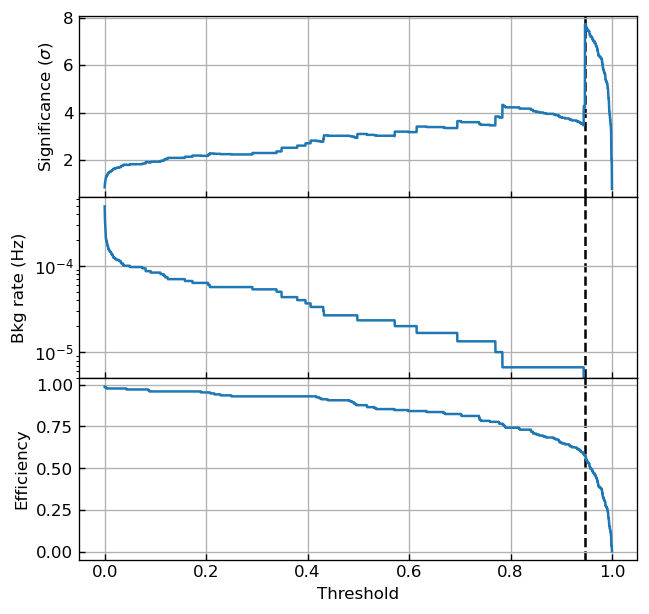

In [219]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_val,
                                                             y_val,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)

For training set

Max significance: 5.58 for threshold 0.9131 background rate 1.68e-06 and analysis efficiency 0.68


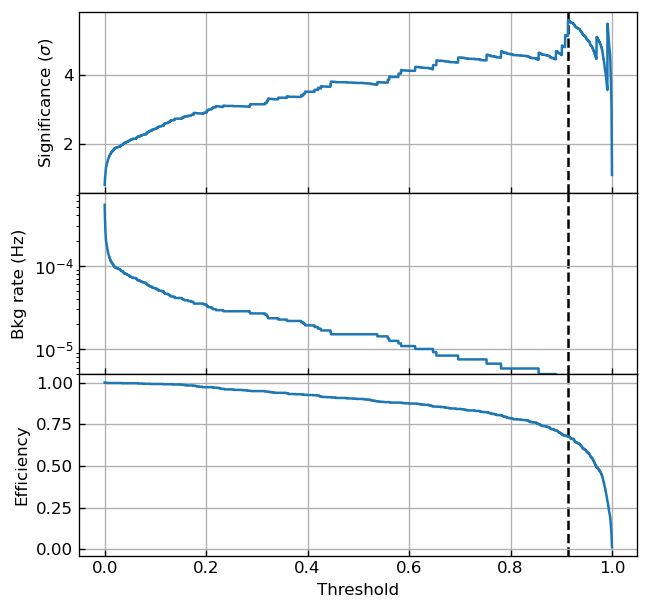

In [220]:
fig=plt.figure(dpi=120, figsize=(6,2*3))
ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                             X_train,
                                                             y_train,
                                                             t_obs_hours=t_tot_hrs,
                                                             N_tot=y_train.size + y_val.size + sd.y_test.size)
plt.subplots_adjust(hspace=0.)
plt.savefig(f"{prefix:s}_perfomance_vs_thr.png")

Significance for test set with the threshold obtained from training set:

In [221]:
imax = np.argmax(significance)

In [222]:
y_pred = model.predict(X_val)

In [223]:
thr = threshold[imax]
#thr = 0.5
class_pred_val, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=thr)
print(thr)
sig, bkg_rate, eff = get_sig_bkg_rate_eff(y_val,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )
print(sig, bkg_rate, eff)

0.9131
3.7532957167303778 6.703688263025196e-06 0.6432748538011696


In [224]:
y_pred = model.predict(X_test)

In [228]:
thr = threshold[imax]
#thr = 0.5
class_pred_test, tp, fp, fn = get_tp_fp_fn(sd.y_test, y_pred, thr=thr)

sig, bkg_rate, eff = get_sig_bkg_rate_eff(sd.y_test,
                                          y_pred,
                                          N_tot=y_train.size + y_val.size + sd.y_test.size,
                                          t_obs=t_tot_hrs * 3600.,
                                          thr=thr
                                         )

In [229]:
print(sig, bkg_rate, eff)

4.035571663921279 5.362950610420157e-06 0.6448598130841121


Plot false positives for test set

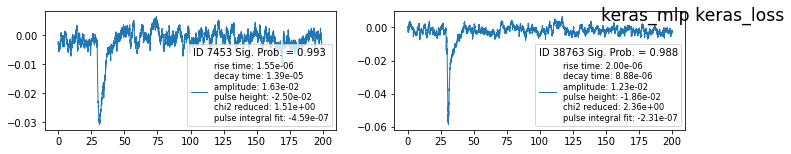

In [230]:
d = {}
d['y_test'] = sd.y_test
scorer = 'keras_loss'
d['y_pred_test'] = {scorer: class_pred_test}
d['idx_test'] = sd.idx_test
d['prob_test'] = {scorer: np.hstack([1. - y_pred, y_pred])}
d['classifier'] = "keras_mlp"

if fp.sum() < 50:
    ax = MLHyperParTuning.plot_misidentified_time_lines(
        d, scorer,
        data['time'],
        data['data'],
        X=X,  # give original data, for right values in legend
        feature_names=feature_names,
        plot_false_positive=True, save_plot=False
    )
plt.savefig(f"{prefix:s}_{thr:.2f}_miss_ids.png")

### Learning curve

In [44]:
np.random.seed(42)
idx = np.arange(y_log.size)
np.random.shuffle(idx)
print(X_log[idx].shape)

sample_sizes, results_train, results_test = learning_curve(model, X_log[idx], y_log[idx], random_state=42, normalizer=normalizer, epochs=100)

(40412, 6)


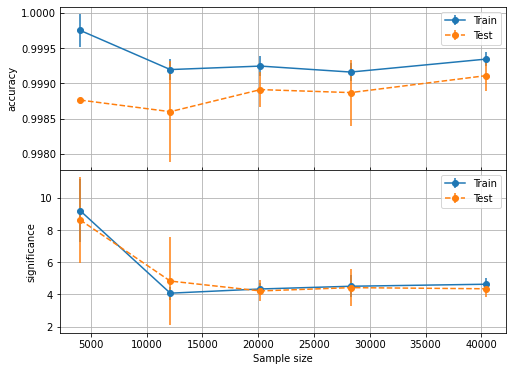

In [45]:
plt.figure(figsize=(8,6))
for i, k in enumerate(['accuracy', 'significance']):
    ax = plt.subplot(2,1,i+1)
    if not i:
        ax.tick_params(direction='in', labelbottom=False)
    plt.errorbar(sample_sizes, results_train[k].mean(axis=-1), yerr=np.sqrt(results_train[k].var(axis=-1)), marker='o', ls='-', color="C0", label="Train")
    plt.errorbar(sample_sizes, results_test[k].mean(axis=-1), yerr=np.sqrt(results_test[k].var(axis=-1)), marker='o', label="Test", ls='--', color="C1")
    plt.legend()
    ax.grid(which='both')
    ax.set_ylabel(k)
plt.subplots_adjust(hspace=0.)
ax.set_xlabel("Sample size")
plt.savefig(f"{prefix:s}_learning_curve.png")

In [46]:
model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0, return_dict=True)

{'loss': 0.0027402015402913094,
 'tp': 680.0,
 'fp': 16.0,
 'tn': 25164.0,
 'fn': 3.0,
 'accuracy': 0.9992653727531433,
 'precision': 0.977011501789093,
 'recall': 0.9956076145172119,
 'auc': 0.99991774559021,
 'prc': 0.9957250952720642,
 'significance': 4.281110763549805}

### Repeat analysis over different folds

In [47]:
n_nodes = 100
n_layers = 5
l2_regularizer = None
dropout = 0.1

0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2b02bd160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4265bd040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:04:33.786584: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:33.786616: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:33.787856: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x71ec19ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 8.65 for threshold 0.9850 background rate 0.00e+00 and analysis efficiency 0.72
1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x4265371f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b107ef70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:04:58.149281: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:58.149409: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04:58.149746: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:04

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29deab550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 6.91 for threshold 0.9991 background rate 0.00e+00 and analysis efficiency 0.46
2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29de775e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b0fe7ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:05:23.383205: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:23.383332: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:23.383345: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x2b136dc10> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 7.12 for threshold 0.9816 background rate 0.00e+00 and analysis efficiency 0.49
3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x71eca6dc0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4265c8550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:05:48.178106: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:48.178664: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05:48.178783: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:05

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x29db8c280> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 7.52 for threshold 0.9974 background rate 0.00e+00 and analysis efficiency 0.54
4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x29dbd5ee0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b11fb9d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-09-01 14:06:13.909892: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06:13.910010: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06:13.910024: W tensorflow/compiler/tf2mlcompute/convert/mlc_convert_utils.cc:690] ComputeTimeStepForAdam: Computing time_step from beta1_power and beta2_power gives different results, probably due to losing precision in pow or log. The time_step that comes from the larger beta_power is chosen (time_step = 975).
2021-09-01 14:06

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ag_logging.py: 146 --- WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0xaa69a0af0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Max significance: 8.02 for threshold 0.9862 background rate 0.00e+00 and analysis efficiency 0.62


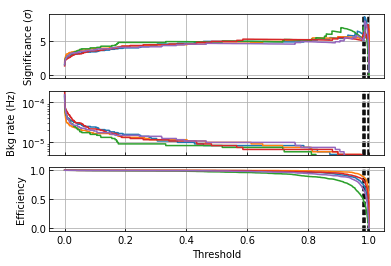

In [48]:
sig, br, ef = np.zeros(5), np.zeros(5), np.zeros(5)

for i in range(5):
    print(i)
    X_train, X_val, y_train, y_val = sd.get_split_with_test_set(m=i, n=0)
    
    # normalize the input data
    normalizer = Normalization(axis=-1)

    # adapt to training data
    normalizer.adapt(X_train)

    # normalize training data
    X_train = normalizer(X_train)
    X_val = normalizer(X_val)
    
    # calculate initial bias
    initial_bias, initial_loss = models.initial_output_bias(y_train)
    
    # the model
    model = models.make_mlp_model(n_features=X_train.shape[1],
                              n_layers=n_layers,
                              n_nodes=n_nodes,
                              l2_regularizer=l2_regularizer,
                              dropout=dropout,
                              output_bias=initial_bias,
                              learning_rate=3e-4
                             )
    
    # fit the model
    models.train_model(model,
                       X_train,
                       y_train,
                       epochs=EPOCHS,
                       batch_size=BATCH_SIZE,
                       X_val=X_val,
                       y_val=y_val,
                       class_weight=None
                      )
    
    # compute best threshold 
    ax, threshold, significance, bkg_rate, eff = plot_sig_vs_thr(model,
                                                                 X_train,
                                                                 y_train,
                                                                 t_obs_hours=t_tot_hrs,
                                                                 N_tot=y_train.size + y_val.size + sd.y_test.size)
    
    imax = np.argmax(significance)
    y_pred = model.predict(X_val)
    class_pred_test, tp, fp, fn = get_tp_fp_fn(y_val, y_pred, thr=threshold[imax])

    sig[i], br[i], ef[i] = get_sig_bkg_rate_eff(y_val,
                                                y_pred,
                                                N_tot=y_train.size + y_val.size + sd.y_test.size,
                                                t_obs=t_tot_hrs * 3600.,
                                               # thr=threshold[imax]
                                                 thr=0.5
                                               )
    
    del model

In [50]:
mean = np.vstack([sig, br, ef]).mean(axis=1)
std = np.sqrt(np.vstack([sig, br, ef]).var(axis=1))
maximum = np.vstack([sig, br, ef]).max(axis=1)
minimum = np.sqrt(np.vstack([sig, br, ef]).min(axis=1))

print(mean)
print(std)
print(minimum)
print(maximum)

[5.42258357e+00 1.34085301e-05 9.78933609e-01]
[2.55901644e+00 1.01675213e-05 2.23698488e-02]
[1.80836806 0.         0.96730167]
[1.01578297e+01 2.68170601e-05 1.00000000e+00]
